<h1> Session 10. Logistic Regression, Decision Tree using Bank data </h1>
<p>This notebook provides an example code of predicting whether the client will subscribe a term deposit or not 
<br>
<b>Dependent variable (y)</b> - has the client subscribed a term deposit? (1-yes, 0-no)
<br>

The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables
<li>Devide data into training and testing sets
<li>Run Logistic Regression from statsmodels and get summary
<li>Run Logistic Regression from sklearn and get accuracy score
<li>Run Decision tree from sklearn, get accuracy score, visually get tree, get importances of variables, try different max_depth and min_samples_leaf
</ol>
</p>


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [3]:
data=pd.read_csv("bank.csv")

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,30,blue_collar,married,basic_9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high_school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high_school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic_9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin_,married,university_degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [5]:
#no missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp_var_rate      4119 non-null float64
cons_price_idx    4119 non-null float64
cons_conf_idx     4119 non-null float64
euribor3m         4119 non-null float64
nr_employed       4119 non-null float64
y                 4119 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usage: 675.9+ KB


In [7]:
#separating the data into object and numeric subdata
data_numeric=data.select_dtypes(exclude="object")
data_object=data.select_dtypes(include="object")

In [8]:
#checking for 0 variance
#there is no variable with 0 var, so we will keep all numeric variables
data_numeric.var()==0

age               False
duration          False
campaign          False
pdays             False
previous          False
emp_var_rate      False
cons_price_idx    False
cons_conf_idx     False
euribor3m         False
nr_employed       False
y                 False
dtype: bool

In [9]:
#checking to see whether there is object variable with one category, if there is one, we should remove
for i in data_object.columns:
    print(data_object[i].unique())

['blue_collar' 'services' 'admin_' 'entrepreneur' 'self_employed'
 'technician' 'management' 'student' 'retired' 'housemaid' 'unemployed'
 'unknown']
['married' 'single' 'divorced' 'unknown']
['basic_9y' 'high_school' 'university_degree' 'professional_course'
 'basic_6y' 'basic_4y' 'unknown' 'illiterate']
['no' 'unknown' 'yes']
['yes' 'no' 'unknown']
['no' 'unknown' 'yes']
['cellular' 'telephone']
['may' 'jun' 'nov' 'sep' 'jul' 'aug' 'mar' 'oct' 'apr' 'dec']
['fri' 'wed' 'mon' 'thu' 'tue']
['nonexistent' 'failure' 'success']


In [10]:
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

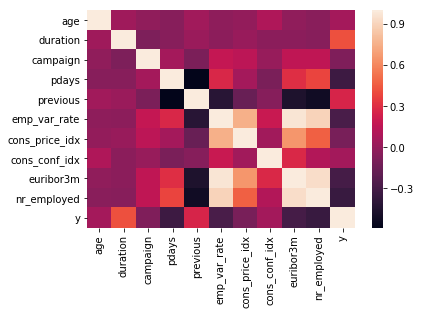

In [11]:
sns.heatmap(data_numeric.corr())

In [12]:
data_final=data_numeric.join(data_dummies)

# Logistic Regression

In [15]:
#let's see percenatage of customers who didn't subscribe to term deposit,
#and percenatage of customers who subscribed to term deposit
data_final.y.value_counts()/len(data_final)*100

0    89.05074
1    10.94926
Name: y, dtype: float64

89% of customers haven't subscribed to deposit.This means that without any model we will probably clasify a new record (a new customer) as 0, but we want to do better than this very naive classification. 

In [17]:
Y=data_final.y
X=data_final.drop("y",axis=1)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [18]:
#to run logit from statsmodel, we should get formula
formula='y~'+'+'.join(X.columns.tolist())
formula

'y~age+duration+campaign+pdays+previous+emp_var_rate+cons_price_idx+cons_conf_idx+euribor3m+nr_employed+job_blue_collar+job_entrepreneur+job_housemaid+job_management+job_retired+job_self_employed+job_services+job_student+job_technician+job_unemployed+job_unknown+marital_married+marital_single+marital_unknown+education_basic_6y+education_basic_9y+education_high_school+education_illiterate+education_professional_course+education_university_degree+education_unknown+default_unknown+default_yes+housing_unknown+housing_yes+loan_unknown+loan_yes+contact_telephone+month_aug+month_dec+month_jul+month_jun+month_mar+month_may+month_nov+month_oct+month_sep+day_of_week_mon+day_of_week_thu+day_of_week_tue+day_of_week_wed+poutcome_nonexistent+poutcome_success'

In [19]:
#using statsmodel for interpretability
logit=Logit.from_formula(formula=formula, data=data_final).fit()

Optimization terminated successfully.
         Current function value: 0.193937
         Iterations 17


In [20]:
logit.summary()

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4119
Model:                          Logit   Df Residuals:                     4066
Method:                           MLE   Df Model:                           52
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:                  0.4386
Time:                        22:23:18   Log-Likelihood:                -798.83
converged:                       True   LL-Null:                       -1422.9
                                        LLR p-value:                4.652e-227
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -144.7479    127.746     -1.133      0.257    -395.125     105.629
age                               0.0087      0.008      1.061      0.289      -0.007       0.025
duration                          0.0053      0.000     19.653      0.000       0.005       0.006
campaign                         -0.0999      0.090     -1.104      0.270      -0.277       0.077
pdays                            -0.0005      0.001     -0.594      0.553      -0.002       0.001
previous                          0.1213        nan        nan        nan         nan         nan
emp_var_rate                     -0.8653      0.408     -2.122      0.034      -1.664      -0.066
cons_price_idx                    1.4090      0.280      5.026      0.000       0.860       1.959
cons_conf_idx                     0.0644      0.024      2.662      0.008       0.017       0.112
euribor3m                        -0.1610      0.325     -0.496      0.620      -0.797       0.475
nr_employed                       0.0022      0.007      0.299      0.765      -0.012       0.016
job_blue_collar                  -0.2269      0.266     -0.854      0.393      -0.747       0.294
job_entrepreneur                 -0.7740      0.492     -1.574      0.116      -1.738       0.190
job_housemaid                     0.2477      0.429      0.578      0.564      -0.593       1.088
job_management                   -0.3136      0.287     -1.093      0.274      -0.876       0.249
job_retired                      -0.2069      0.346     -0.598      0.550      -0.885       0.472
job_self_employed                -0.7305      0.421     -1.737      0.082      -1.555       0.094
job_services                      0.1251      0.269      0.466      0.642      -0.402       0.652
job_student                      -0.0737      0.383     -0.193      0.847      -0.823       0.676
job_technician                    0.2209      0.225      0.980      0.327      -0.221       0.663
job_unemployed                    0.3362      0.389      0.864      0.388      -0.427       1.099
job_unknown                      -0.4624      0.743     -0.622      0.534      -1.919       0.994
marital_married                   0.2782      0.253      1.100      0.271      -0.217       0.774
marital_single                    0.3277      0.278      1.177      0.239      -0.218       0.873
marital_unknown                   0.2769      1.152      0.240      0.810      -1.980       2.534
education_basic_6y                0.3219      0.407      0.790      0.430      -0.477       1.121
education_basic_9y                0.2012      0.315      0.639      0.523      -0.416       0.818
education_high_school             0.1515      0.306      0.495      0.620      -0.448       0.751
education_illiterate           -133.4698   2.78e+29  -4.81e-28      1.000   -5.44e+29    5.44e+29
education_professional_course     0.1169      0.337      0.347      0.728      -0.543       0.776
educati

<b>Interpreting the coef of cons_price_idx: As can be seen from the summary p-value of cons_price_idx is positive, so there is statistically significant relationship between cons_price_idx and probability of subscribing to deposit. As the coef of cons_price_idx is positive (1.4090, see in summary), then the unit increase of cons_price_idx increases the probability of sunsvribing to deposit. </b>

In [21]:
#Logit from skleran for prediction
logit_sk=LogisticRegression()

In [23]:
logit_sk=logit_sk.fit(x_train,y_train)

In [24]:
#get accuracy score
logit_sk.score(x_test,y_test)

0.9106796116504854

# Decision Tree

In [25]:
#running and fitting DT
tree_1=DecisionTreeClassifier(random_state=42)
tree_1.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [27]:
importances=tree_1.feature_importances_
importances=pd.DataFrame(data=importances, index=X.columns, columns=['importances'])

In [29]:
#only first two variables have comparatively higher importances, the importance of other variables is lower
importances.sort_values(by="importances", ascending=False)

,importances
duration,0.361635
nr_employed,0.170502
age,0.061276
euribor3m,0.047205
cons_conf_idx,0.046274
campaign,0.029946
previous,0.023490
pdays,0.019555
cons_price_idx,0.016906
marital_married,0.015161


In [30]:
#let's visually see the tree
tree_gr=export_graphviz(tree_1,out_file="tree2.dot", class_names=True, feature_names=X.columns, filled=True) 
#Go to http://webgraphviz.com/, enter the code from the word file saved

In [31]:
#get accuracy score
#the accuracy is lower than in Logistic regression
tree_1.score(x_test,y_test)

0.8941747572815534

In [32]:
#let's cut the tree and check accuarcy again
tree_2=DecisionTreeClassifier(max_depth=3,min_samples_leaf=100,random_state=42)
tree_2.fit(x_train,y_train)
tree_2.score(x_test,y_test)

0.9048543689320389

<b>As can be seen from the new tree, the accuracy is higher</b>

In [33]:
#let's visually see new tree
tree_gr2=export_graphviz(tree_2,out_file="tree2.dot", class_names=True, feature_names=X.columns, filled=True) 
#Go to http://webgraphviz.com/, enter the code from the word file saved